In [1]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import medmnist
from medmnist import INFO, Evaluator
import os
import time
import torch.nn as nn
import torch
import torchvision.transforms as transforms
from PIL import Image
from matplotlib import pyplot as plt
import torchvision.models as models
import torchsummary
import time
from torch.optim.lr_scheduler import ExponentialLR


In [2]:
%run /models/resnet.py

In [3]:
cd /

/


/usr/local/lib/python3.11/dist-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
import sys
sys.path.append('/models')
from models import resnet

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device =',device)
print(torch.cuda.get_device_name(0))


device = cuda:0
NVIDIA RTX A4000


In [6]:
def generate_model(model_type='resnet', model_depth=18,
                   input_W=224, input_H=224, input_D=224, resnet_shortcut='B',
                   no_cuda=False, gpu_id=[0],
                   pretrain_path = '/MedicalNet/pretrain/resnet_18.pth',
                   nb_class=11):
    assert model_type in [
        'resnet'
    ]

    if model_type == 'resnet':
        assert model_depth in [10, 18, 34, 50, 101, 152, 200]

    if model_depth == 10:
        model = resnet.resnet10(
            sample_input_W=input_W,
            sample_input_H=input_H,
            sample_input_D=input_D,
            shortcut_type=resnet_shortcut,
            no_cuda=no_cuda,
            num_seg_classes=1)
        fc_input = 256
    elif model_depth == 18:
        model = resnet.resnet18(
            sample_input_W=input_W,
            sample_input_H=input_H,
            sample_input_D=input_D,
            shortcut_type=resnet_shortcut,
            no_cuda=no_cuda,
            num_seg_classes=1)
        fc_input = 512
    elif model_depth == 34:
        model = resnet.resnet34(
            sample_input_W=input_W,
            sample_input_H=input_H,
            sample_input_D=input_D,
            shortcut_type=resnet_shortcut,
            no_cuda=no_cuda,
            num_seg_classes=1)
        fc_input = 512
    elif model_depth == 50:
        model = resnet.resnet50(
            sample_input_W=input_W,
            sample_input_H=input_H,
            sample_input_D=input_D,
            shortcut_type=resnet_shortcut,
            no_cuda=no_cuda,
            num_seg_classes=1)
        fc_input = 2048
    elif model_depth == 101:
        model = resnet.resnet101(
            sample_input_W=input_W,
            sample_input_H=input_H,
            sample_input_D=input_D,
            shortcut_type=resnet_shortcut,
            no_cuda=no_cuda,
            num_seg_classes=1)
        fc_input = 2048
    elif model_depth == 152:
        model = resnet.resnet152(
            sample_input_W=input_W,
            sample_input_H=input_H,
            sample_input_D=input_D,
            shortcut_type=resnet_shortcut,
            no_cuda=no_cuda,
            num_seg_classes=1)
        fc_input = 2048
    elif model_depth == 200:
        model = resnet.resnet200(
            sample_input_W=input_W,
            sample_input_H=input_H,
            sample_input_D=input_D,
            shortcut_type=resnet_shortcut,
            no_cuda=no_cuda,
            num_seg_classes=1)
        fc_input = 2048

    model.conv_seg = nn.Sequential(nn.AdaptiveAvgPool3d((1, 1, 1)), nn.Flatten(),
                                   nn.Linear(in_features=fc_input, out_features=nb_class, bias=True))

    if not no_cuda:
        if len(gpu_id) > 1:
            model = model.cuda()
            model = nn.DataParallel(model, device_ids=gpu_id)
            net_dict = model.state_dict()
        else:
            import os
            os.environ["CUDA_VISIBLE_DEVICES"]=str(gpu_id[0])
            model = model.cuda()
            model = nn.DataParallel(model, device_ids=None)
            net_dict = model.state_dict()
    else:
        net_dict = model.state_dict()

    print('loading pretrained model {}'.format(pretrain_path))
    pretrain = torch.load(pretrain_path)
    pretrain_dict = {k: v for k, v in pretrain['state_dict'].items() if k in net_dict.keys()}
    # k 是每一层的名称，v是权重数值
    net_dict.update(pretrain_dict) #字典 dict2 的键/值对更新到 dict 里。
    model.load_state_dict(net_dict) #model.load_state_dict()函数把加载的权重复制到模型的权重中去

    print("-------- pre-train model load successfully --------")

    return model


In [7]:
model = generate_model(model_type='resnet', model_depth=18,
                   input_W=224, input_H=224, input_D=224, resnet_shortcut='B',
                   no_cuda=False, gpu_id=[0],
                   pretrain_path = '/MedicalNet/pretrain/resnet_18_23dataset.pth',
                   nb_class=11)


/models/resnet.py:173: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out')


loading pretrained model /MedicalNet/pretrain/resnet_18_23dataset.pth
-------- pre-train model load successfully --------


In [8]:
from torch.utils.tensorboard import SummaryWriter

summaryWriter = SummaryWriter("./logs/")


In [9]:
batch_size = 8


In [10]:
#生成txt文档，每一行:xxx.nii 空格 类别
import os
import random
random.seed(3407)
classifier = {"experimental":0,"control":1}

path_origin = '/hy-tmp/Abeta_4D_resize2/Train/'
train_txt = open(os.path.join(path_origin,'train_list.txt'),'w')
val_txt = open(os.path.join(path_origin,'val_list.txt'),'w')

for k in classifier.keys():
    classifier_path = os.path.join(path_origin,k)
   # classifier_path = path_origin
    fileList = []
    for root, dirs, files in os.walk(classifier_path):
            for fileObj in files:
                fileList.append(os.path.join(root, fileObj))
    files = list(filter(lambda x: x.endswith('.nii'), fileList))
    random.shuffle(files)
    rate = int(len(files) * 0.9)#训练集和测试集9：1
    for i,f_path in enumerate(files):
        if i < rate:
            train_txt.write(f_path + ' ' + str(classifier[k])+ '\n')
        else:
            val_txt.write(f_path + ' ' + str(classifier[k])+ '\n')
train_txt.close()
val_txt.close()
print('完成')

import os
import random
random.seed(3407)
classifier = {"experimental":0,"control":1}

path_origin = '/hy-tmp/Abeta_4D_resize2/Test/'
test_txt = open('/hy-tmp/Abeta_4D_resize2/test_list.txt','w')

classifier_path = path_origin
fileList = []
for root, dirs, files in os.walk(classifier_path):
        for fileObj in files:
            fileList.append(os.path.join(root, fileObj))
files = list(filter(lambda x: x.endswith('.nii'), fileList))
random.shuffle(files)
rate = 0
for i,f_path in enumerate(files):
    if i >= rate:
        test_txt.write(f_path + ' ' + str(0)+ '\n')     
test_txt.close()
print('完成')



完成
完成


In [11]:
import random

# 要打乱并覆盖的文件路径
file_path = '/hy-tmp/Abeta_4D_resize2/Train/train_list.txt'

# 读取文件内容
with open(file_path, 'r') as file:
    lines = file.readlines()

# 打乱行顺序
random.shuffle(lines)

# 将打乱后的行写回同一个文件，覆盖原始内容
with open(file_path, 'w') as file:
    for line in lines:
        file.write(line)

print(f"文件 '{file_path}' 中的行顺序已被打乱并覆盖原文件。")


# 要打乱并覆盖的文件路径
file_path = '/hy-tmp/Abeta_4D_resize2/Train/val_list.txt'

# 读取文件内容
with open(file_path, 'r') as file:
    lines = file.readlines()

# 打乱行顺序
random.shuffle(lines)

# 将打乱后的行写回同一个文件，覆盖原始内容
with open(file_path, 'w') as file:
    for line in lines:
        file.write(line)

print(f"文件 '{file_path}' 中的行顺序已被打乱并覆盖原文件。")

文件 '/hy-tmp/Abeta_4D_resize2/Train/train_list.txt' 中的行顺序已被打乱并覆盖原文件。
文件 '/hy-tmp/Abeta_4D_resize2/Train/val_list.txt' 中的行顺序已被打乱并覆盖原文件。


In [12]:

#创建DataSet 和Transform 用来读取医疗数据，并转换成numpy，归一化，重采样合适的大小
import numpy as np
import os
import SimpleITK as sitk
from paddle.io import Dataset 

#SIZE = (64,256,256)

class MyDataset(Dataset):
    def __init__(self, data_dir, mode='train',transform=None):
        super().__init__()
        self.data_dir = data_dir
        self.transform = transform
        self.data_paths = []
        self.labels = []

        if mode == 'train':
            with open(os.path.join(self.data_dir, "train_list.txt"), "r", encoding="utf-8") as f:
                info = f.readlines()
            for img_info in info:
                img_path, label = img_info.split()
                self.data_paths.append(img_path)
                self.labels.append(int(label))

        elif mode == 'val':
            with open(os.path.join(self.data_dir, "val_list.txt"), "r", encoding="utf-8") as f:
                info = f.readlines()
            for img_info in info:
                img_path, label = img_info.split()
              #  print(img_path)
                self.data_paths.append(img_path)
                self.labels.append(int(label))

        elif mode == 'test':
            with open("/hy-tmp/Abeta_4D_resize2/Test_list.txt", "r", encoding="utf-8") as f:
                info = f.readlines()
            for img_info in info:
                img_path, label = img_info.split()
                print(img_path)
                self.data_paths.append(img_path)
                self.labels.append(int(label))
        

    def __getitem__(self, index):
        img_path = self.data_paths[index]
       # mask_path = img_path.replace('t2.nii','seg.nii')
        data = self.read_Nifit(img_path)
      #  mask = self.read_Nifit(mask_path)
       # data = self.maskcroppingbox(data,mask)
        if data.ndim != 3:
            raise("  ")
        if self.transform is not None:
            data = self.transform(data)
        data = np.expand_dims(data, axis=0)
        label = self.labels[index]
        label = np.array([label], dtype="int32")
        #data = np.ascontiguousarray(data)
        return data, label

    def read_Nifit(self,path):
        sitkImg = sitk.ReadImage(path)
        npImg = sitk.GetArrayFromImage(sitkImg)
        npImg = npImg.astype('float32')
        return npImg

    #此函数需要对数据集进行mask标注
    def maskcroppingbox(self,img,mask, use2D=False):
        #根据mask范围进行裁剪
        mask_2 = np.argwhere(mask)
        (zstart, ystart, xstart), (zstop, ystop, xstop) = mask_2.min(axis=0), mask_2.max(axis=0) + 1
        
        roi_image = img[zstart-1:zstop+1,ystart:ystop,xstart:xstop]
        roi_mask = mask[zstart-1:zstop+1,ystart:ystop,xstart:xstop]
        roi_image[roi_mask<1]=0
        return roi_image

    def __len__(self):
        return len(self.data_paths)

train_dataset = MyDataset('/hy-tmp/Abeta_4D_resize2/Train/',mode='train',transform=None)
val_dataset = MyDataset('/hy-tmp/Abeta_4D_resize2/Train/',mode='val',transform=None)
test_dataset = MyDataset('/hy-tmp/Abeta_4D_resize2/Test/',mode='test',transform=None)

/hy-tmp/Abeta_4D_resize/Test/1.nii
/hy-tmp/Abeta_4D_resize/Test/2.nii
/hy-tmp/Abeta_4D_resize/Test/3.nii
/hy-tmp/Abeta_4D_resize/Test/4.nii
/hy-tmp/Abeta_4D_resize/Test/5.nii
/hy-tmp/Abeta_4D_resize/Test/6.nii
/hy-tmp/Abeta_4D_resize/Test/7.nii
/hy-tmp/Abeta_4D_resize/Test/8.nii
/hy-tmp/Abeta_4D_resize/Test/9.nii
/hy-tmp/Abeta_4D_resize/Test/10.nii
/hy-tmp/Abeta_4D_resize/Test/11.nii
/hy-tmp/Abeta_4D_resize/Test/12.nii
/hy-tmp/Abeta_4D_resize/Test/13.nii
/hy-tmp/Abeta_4D_resize/Test/14.nii
/hy-tmp/Abeta_4D_resize/Test/15.nii
/hy-tmp/Abeta_4D_resize/Test/16.nii
/hy-tmp/Abeta_4D_resize/Test/17.nii
/hy-tmp/Abeta_4D_resize/Test/18.nii
/hy-tmp/Abeta_4D_resize/Test/19.nii
/hy-tmp/Abeta_4D_resize/Test/20.nii
/hy-tmp/Abeta_4D_resize/Test/21.nii
/hy-tmp/Abeta_4D_resize/Test/22.nii
/hy-tmp/Abeta_4D_resize/Test/23.nii
/hy-tmp/Abeta_4D_resize/Test/24.nii
/hy-tmp/Abeta_4D_resize/Test/25.nii
/hy-tmp/Abeta_4D_resize/Test/26.nii
/hy-tmp/Abeta_4D_resize/Test/27.nii
/hy-tmp/Abeta_4D_resize/Test/28.nii
/

In [14]:
#查看数据集的形状
import glob
import nibabel as nib
path=glob.glob('/hy-tmp/Abeta_4D_resize2/Train/*/*')
path2=glob.glob('/hy-tmp/Abeta_4D_resize2/Test/*')
sizeSet=set()
 
for i in path:
    im=nib.load(i)
    im_data=np.array(im.get_fdata())
    sizeSet.add(im_data.shape)
    
for i in path2:
    im=nib.load(i)
    im_data=np.array(im.get_fdata())
    sizeSet.add(im_data.shape)
 
print(sizeSet)

{(64, 256, 256)}


In [16]:
train_loader = data.DataLoader(dataset=train_dataset,
                            batch_size=batch_size,
                            shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset,
                            batch_size=batch_size,
                            shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset,
                            batch_size=batch_size,
                            shuffle=False)


In [17]:
#检查数据
for x, y in train_loader:
    print(x.shape, y.shape)
    break
# torch.Size([256, 1, 28, 28, 28]) torch.Size([256, 1])


torch.Size([8, 1, 256, 256, 64]) torch.Size([8, 1])


In [18]:
from models import resnet


In [19]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device =',device)
print(torch.cuda.get_device_name(0))


device = cuda:0
NVIDIA RTX A4000


In [20]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()
scheduler = ExponentialLR(optimizer, gamma=0.99)
num_epochs = 200

In [21]:
def save_model(model, save_path):
    torch.save(model.state_dict(), save_path)   #需要增加model.state_dict()，否则加载有问题
    print(f"Model saved to {save_path}")

CUDA is available.


100%|██████████| 9/9 [00:11<00:00,  1.31s/it]


Train Epoch: 0	 Loss: 1.964512	 Acc: 0.250000


100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


val Epoch: 0	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


Test Epoch: 0	 Test_Acc: 0.250000
/validation/validation_results0.csv


100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Train Epoch: 1	 Loss: 0.912539	 Acc: 0.388889


100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


val Epoch: 1	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:02<00:00,  2.50it/s]


Test Epoch: 1	 Test_Acc: 0.277778
/validation/validation_results1.csv


100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Train Epoch: 2	 Loss: 0.770520	 Acc: 0.555556


100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


val Epoch: 2	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


Test Epoch: 2	 Test_Acc: 0.750000
/validation/validation_results2.csv


100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


Train Epoch: 3	 Loss: 0.749368	 Acc: 0.444444


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


val Epoch: 3	 Val_Acc: 0.375000


100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


Test Epoch: 3	 Test_Acc: 0.777778
/validation/validation_results3.csv


100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Train Epoch: 4	 Loss: 0.720451	 Acc: 0.527778


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


val Epoch: 4	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.56it/s]


Test Epoch: 4	 Test_Acc: 0.722222
/validation/validation_results4.csv


100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


Train Epoch: 5	 Loss: 0.698089	 Acc: 0.500000


100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


val Epoch: 5	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


Test Epoch: 5	 Test_Acc: 0.750000
/validation/validation_results5.csv


100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


Train Epoch: 6	 Loss: 0.801298	 Acc: 0.513889


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


val Epoch: 6	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


Test Epoch: 6	 Test_Acc: 0.750000
/validation/validation_results6.csv


100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


Train Epoch: 7	 Loss: 0.693259	 Acc: 0.583333


100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


val Epoch: 7	 Val_Acc: 0.625000


100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


Test Epoch: 7	 Test_Acc: 0.472222
/validation/validation_results7.csv


100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Train Epoch: 8	 Loss: 0.719830	 Acc: 0.486111


100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


val Epoch: 8	 Val_Acc: 0.750000


100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


Test Epoch: 8	 Test_Acc: 0.527778
/validation/validation_results8.csv


100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Train Epoch: 9	 Loss: 0.705451	 Acc: 0.611111


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


val Epoch: 9	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.56it/s]


Test Epoch: 9	 Test_Acc: 0.750000
/validation/validation_results9.csv


100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Train Epoch: 10	 Loss: 0.653336	 Acc: 0.625000


100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


val Epoch: 10	 Val_Acc: 0.375000


100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


Test Epoch: 10	 Test_Acc: 0.777778
/validation/validation_results10.csv


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 11	 Loss: 0.705697	 Acc: 0.611111


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


val Epoch: 11	 Val_Acc: 0.375000


100%|██████████| 5/5 [00:02<00:00,  2.41it/s]


Test Epoch: 11	 Test_Acc: 0.750000
/validation/validation_results11.csv


100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Train Epoch: 12	 Loss: 0.697781	 Acc: 0.569444


100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


val Epoch: 12	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


Test Epoch: 12	 Test_Acc: 0.750000
/validation/validation_results12.csv


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 13	 Loss: 0.697069	 Acc: 0.486111


100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


val Epoch: 13	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:02<00:00,  2.46it/s]


Test Epoch: 13	 Test_Acc: 0.750000
/validation/validation_results13.csv


100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Train Epoch: 14	 Loss: 0.667979	 Acc: 0.597222


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


val Epoch: 14	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


Test Epoch: 14	 Test_Acc: 0.722222
/validation/validation_results14.csv


100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Train Epoch: 15	 Loss: 0.676264	 Acc: 0.569444


100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


val Epoch: 15	 Val_Acc: 0.625000


100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


Test Epoch: 15	 Test_Acc: 0.694444
/validation/validation_results15.csv


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 16	 Loss: 0.655969	 Acc: 0.597222


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


val Epoch: 16	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


Test Epoch: 16	 Test_Acc: 0.722222
/validation/validation_results16.csv


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 17	 Loss: 0.695510	 Acc: 0.500000


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


val Epoch: 17	 Val_Acc: 0.750000


100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


Test Epoch: 17	 Test_Acc: 0.722222
/validation/validation_results17.csv


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 18	 Loss: 0.685276	 Acc: 0.611111


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


val Epoch: 18	 Val_Acc: 0.625000


100%|██████████| 5/5 [00:02<00:00,  2.48it/s]


Test Epoch: 18	 Test_Acc: 0.750000
/validation/validation_results18.csv


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 19	 Loss: 0.662408	 Acc: 0.541667


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


val Epoch: 19	 Val_Acc: 0.375000


100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


Test Epoch: 19	 Test_Acc: 0.750000
/validation/validation_results19.csv


100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Train Epoch: 20	 Loss: 0.726871	 Acc: 0.527778


100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


val Epoch: 20	 Val_Acc: 0.375000


100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


Test Epoch: 20	 Test_Acc: 0.583333
/validation/validation_results20.csv


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 21	 Loss: 0.689297	 Acc: 0.583333


100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


val Epoch: 21	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


Test Epoch: 21	 Test_Acc: 0.611111
/validation/validation_results21.csv


100%|██████████| 9/9 [00:09<00:00,  1.01s/it]


Train Epoch: 22	 Loss: 0.703747	 Acc: 0.541667


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


val Epoch: 22	 Val_Acc: 0.625000


100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


Test Epoch: 22	 Test_Acc: 0.722222
/validation/validation_results22.csv


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 23	 Loss: 0.720366	 Acc: 0.486111


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


val Epoch: 23	 Val_Acc: 0.625000


100%|██████████| 5/5 [00:01<00:00,  2.50it/s]


Test Epoch: 23	 Test_Acc: 0.583333
/validation/validation_results23.csv


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 24	 Loss: 0.704211	 Acc: 0.527778


100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


val Epoch: 24	 Val_Acc: 0.625000


100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


Test Epoch: 24	 Test_Acc: 0.638889
/validation/validation_results24.csv


100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Train Epoch: 25	 Loss: 0.659740	 Acc: 0.625000


100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


val Epoch: 25	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:02<00:00,  2.50it/s]


Test Epoch: 25	 Test_Acc: 0.777778
/validation/validation_results25.csv


100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Train Epoch: 26	 Loss: 0.675404	 Acc: 0.611111


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


val Epoch: 26	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


Test Epoch: 26	 Test_Acc: 0.750000
/validation/validation_results26.csv


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 27	 Loss: 0.636785	 Acc: 0.555556


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


val Epoch: 27	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


Test Epoch: 27	 Test_Acc: 0.750000
/validation/validation_results27.csv


100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Train Epoch: 28	 Loss: 0.665820	 Acc: 0.597222


100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


val Epoch: 28	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:02<00:00,  2.50it/s]


Test Epoch: 28	 Test_Acc: 0.750000
/validation/validation_results28.csv


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 29	 Loss: 0.685947	 Acc: 0.611111


100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


val Epoch: 29	 Val_Acc: 0.625000


100%|██████████| 5/5 [00:02<00:00,  2.48it/s]


Test Epoch: 29	 Test_Acc: 0.750000
/validation/validation_results29.csv


100%|██████████| 9/9 [00:09<00:00,  1.01s/it]


Train Epoch: 30	 Loss: 0.666630	 Acc: 0.583333


100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


val Epoch: 30	 Val_Acc: 0.750000


100%|██████████| 5/5 [00:02<00:00,  2.50it/s]


Test Epoch: 30	 Test_Acc: 0.583333
/validation/validation_results30.csv


100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Train Epoch: 31	 Loss: 0.695712	 Acc: 0.583333


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


val Epoch: 31	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


Test Epoch: 31	 Test_Acc: 0.777778
/validation/validation_results31.csv


100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Train Epoch: 32	 Loss: 0.627642	 Acc: 0.611111


100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


val Epoch: 32	 Val_Acc: 0.750000


100%|██████████| 5/5 [00:02<00:00,  2.37it/s]


Test Epoch: 32	 Test_Acc: 0.555556
/validation/validation_results32.csv


100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Train Epoch: 33	 Loss: 0.615652	 Acc: 0.625000


100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


val Epoch: 33	 Val_Acc: 0.625000


100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


Test Epoch: 33	 Test_Acc: 0.722222
/validation/validation_results33.csv


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 34	 Loss: 0.672901	 Acc: 0.583333


100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


val Epoch: 34	 Val_Acc: 0.625000


100%|██████████| 5/5 [00:02<00:00,  2.48it/s]


Test Epoch: 34	 Test_Acc: 0.722222
/validation/validation_results34.csv


100%|██████████| 9/9 [00:09<00:00,  1.01s/it]


Train Epoch: 35	 Loss: 0.684553	 Acc: 0.597222


100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


val Epoch: 35	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:02<00:00,  2.45it/s]


Test Epoch: 35	 Test_Acc: 0.777778
/validation/validation_results35.csv


100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Train Epoch: 36	 Loss: 0.595909	 Acc: 0.680556


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


val Epoch: 36	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:02<00:00,  2.47it/s]


Test Epoch: 36	 Test_Acc: 0.750000
/validation/validation_results36.csv


100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Train Epoch: 37	 Loss: 0.577207	 Acc: 0.652778


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


val Epoch: 37	 Val_Acc: 0.375000


100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


Test Epoch: 37	 Test_Acc: 0.777778
/validation/validation_results37.csv


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 38	 Loss: 0.602393	 Acc: 0.666667


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


val Epoch: 38	 Val_Acc: 0.375000


100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


Test Epoch: 38	 Test_Acc: 0.750000
/validation/validation_results38.csv


100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Train Epoch: 39	 Loss: 0.604524	 Acc: 0.666667


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


val Epoch: 39	 Val_Acc: 0.875000


100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


Test Epoch: 39	 Test_Acc: 0.722222
/validation/validation_results39.csv


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 40	 Loss: 0.588326	 Acc: 0.597222


100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


val Epoch: 40	 Val_Acc: 0.750000


100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


Test Epoch: 40	 Test_Acc: 0.722222
/validation/validation_results40.csv


100%|██████████| 9/9 [00:09<00:00,  1.01s/it]


Train Epoch: 41	 Loss: 0.577707	 Acc: 0.680556


100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


val Epoch: 41	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Test Epoch: 41	 Test_Acc: 0.833333
/validation/validation_results41.csv
Model saved to ./weights/model41.pth


100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Train Epoch: 42	 Loss: 0.576722	 Acc: 0.680556


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


val Epoch: 42	 Val_Acc: 0.750000


100%|██████████| 5/5 [00:02<00:00,  2.50it/s]


Test Epoch: 42	 Test_Acc: 0.750000
/validation/validation_results42.csv


100%|██████████| 9/9 [00:09<00:00,  1.01s/it]


Train Epoch: 43	 Loss: 0.562334	 Acc: 0.680556


100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


val Epoch: 43	 Val_Acc: 0.625000


100%|██████████| 5/5 [00:02<00:00,  2.49it/s]


Test Epoch: 43	 Test_Acc: 0.777778
/validation/validation_results43.csv


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 44	 Loss: 0.563729	 Acc: 0.680556


100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


val Epoch: 44	 Val_Acc: 0.375000


100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


Test Epoch: 44	 Test_Acc: 0.833333
/validation/validation_results44.csv
Model saved to ./weights/model44.pth


100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Train Epoch: 45	 Loss: 0.661086	 Acc: 0.611111


100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


val Epoch: 45	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:02<00:00,  2.44it/s]


Test Epoch: 45	 Test_Acc: 0.750000
/validation/validation_results45.csv


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 46	 Loss: 0.683022	 Acc: 0.583333


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


val Epoch: 46	 Val_Acc: 0.375000


100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


Test Epoch: 46	 Test_Acc: 0.638889
/validation/validation_results46.csv


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 47	 Loss: 0.654444	 Acc: 0.583333


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


val Epoch: 47	 Val_Acc: 0.375000


100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


Test Epoch: 47	 Test_Acc: 0.666667
/validation/validation_results47.csv


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 48	 Loss: 0.699991	 Acc: 0.555556


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


val Epoch: 48	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


Test Epoch: 48	 Test_Acc: 0.472222
/validation/validation_results48.csv


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 49	 Loss: 0.600573	 Acc: 0.652778


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


val Epoch: 49	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


Test Epoch: 49	 Test_Acc: 0.527778
/validation/validation_results49.csv


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 50	 Loss: 0.653770	 Acc: 0.597222


100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


val Epoch: 50	 Val_Acc: 0.375000


100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


Test Epoch: 50	 Test_Acc: 0.583333
/validation/validation_results50.csv


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 51	 Loss: 0.565235	 Acc: 0.694444


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


val Epoch: 51	 Val_Acc: 0.375000


100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


Test Epoch: 51	 Test_Acc: 0.611111
/validation/validation_results51.csv


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 52	 Loss: 0.597510	 Acc: 0.625000


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


val Epoch: 52	 Val_Acc: 0.375000


100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


Test Epoch: 52	 Test_Acc: 0.583333
/validation/validation_results52.csv


100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Train Epoch: 53	 Loss: 0.597273	 Acc: 0.694444


100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


val Epoch: 53	 Val_Acc: 0.625000


100%|██████████| 5/5 [00:02<00:00,  2.42it/s]


Test Epoch: 53	 Test_Acc: 0.555556
/validation/validation_results53.csv


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 54	 Loss: 0.571276	 Acc: 0.611111


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


val Epoch: 54	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:02<00:00,  2.48it/s]


Test Epoch: 54	 Test_Acc: 0.611111
/validation/validation_results54.csv


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 55	 Loss: 0.585992	 Acc: 0.652778


100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


val Epoch: 55	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


Test Epoch: 55	 Test_Acc: 0.666667
/validation/validation_results55.csv


100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Train Epoch: 56	 Loss: 0.536938	 Acc: 0.680556


100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


val Epoch: 56	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


Test Epoch: 56	 Test_Acc: 0.694444
/validation/validation_results56.csv


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 57	 Loss: 0.580261	 Acc: 0.708333


100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


val Epoch: 57	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


Test Epoch: 57	 Test_Acc: 0.611111
/validation/validation_results57.csv


100%|██████████| 9/9 [00:09<00:00,  1.01s/it]


Train Epoch: 58	 Loss: 0.576436	 Acc: 0.722222


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


val Epoch: 58	 Val_Acc: 0.375000


100%|██████████| 5/5 [00:01<00:00,  2.50it/s]


Test Epoch: 58	 Test_Acc: 0.777778
/validation/validation_results58.csv


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 59	 Loss: 0.503281	 Acc: 0.777778


100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


val Epoch: 59	 Val_Acc: 0.625000


100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


Test Epoch: 59	 Test_Acc: 0.777778
/validation/validation_results59.csv


100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Train Epoch: 60	 Loss: 0.569298	 Acc: 0.694444


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


val Epoch: 60	 Val_Acc: 0.375000


100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


Test Epoch: 60	 Test_Acc: 0.777778
/validation/validation_results60.csv


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 61	 Loss: 0.508500	 Acc: 0.694444


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


val Epoch: 61	 Val_Acc: 0.750000


100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


Test Epoch: 61	 Test_Acc: 0.833333
/validation/validation_results61.csv
Model saved to ./weights/model61.pth


100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Train Epoch: 62	 Loss: 0.512390	 Acc: 0.722222


100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


val Epoch: 62	 Val_Acc: 0.625000


100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


Test Epoch: 62	 Test_Acc: 0.750000
/validation/validation_results62.csv


100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Train Epoch: 63	 Loss: 0.468614	 Acc: 0.750000


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


val Epoch: 63	 Val_Acc: 0.750000


100%|██████████| 5/5 [00:02<00:00,  2.48it/s]


Test Epoch: 63	 Test_Acc: 0.833333
/validation/validation_results63.csv
Model saved to ./weights/model63.pth


100%|██████████| 9/9 [00:09<00:00,  1.01s/it]


Train Epoch: 64	 Loss: 0.454489	 Acc: 0.750000


100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


val Epoch: 64	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


Test Epoch: 64	 Test_Acc: 0.722222
/validation/validation_results64.csv


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 65	 Loss: 0.535152	 Acc: 0.652778


100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


val Epoch: 65	 Val_Acc: 0.625000


100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


Test Epoch: 65	 Test_Acc: 0.833333
/validation/validation_results65.csv
Model saved to ./weights/model65.pth


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 66	 Loss: 0.485329	 Acc: 0.680556


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


val Epoch: 66	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


Test Epoch: 66	 Test_Acc: 0.805556
/validation/validation_results66.csv


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 67	 Loss: 0.463174	 Acc: 0.722222


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


val Epoch: 67	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


Test Epoch: 67	 Test_Acc: 0.694444
/validation/validation_results67.csv


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 68	 Loss: 0.515718	 Acc: 0.736111


100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


val Epoch: 68	 Val_Acc: 0.625000


100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


Test Epoch: 68	 Test_Acc: 0.861111
/validation/validation_results68.csv
Model saved to ./weights/model68.pth


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 69	 Loss: 0.477439	 Acc: 0.736111


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


val Epoch: 69	 Val_Acc: 0.625000


100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


Test Epoch: 69	 Test_Acc: 0.805556
/validation/validation_results69.csv


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 70	 Loss: 0.477780	 Acc: 0.722222


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


val Epoch: 70	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:02<00:00,  2.48it/s]


Test Epoch: 70	 Test_Acc: 0.861111
/validation/validation_results70.csv
Model saved to ./weights/model70.pth


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 71	 Loss: 0.430659	 Acc: 0.777778


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


val Epoch: 71	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


Test Epoch: 71	 Test_Acc: 0.861111
/validation/validation_results71.csv
Model saved to ./weights/model71.pth


100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Train Epoch: 72	 Loss: 0.443154	 Acc: 0.777778


100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


val Epoch: 72	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:02<00:00,  2.48it/s]


Test Epoch: 72	 Test_Acc: 0.805556
/validation/validation_results72.csv


100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Train Epoch: 73	 Loss: 0.401999	 Acc: 0.833333


100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


val Epoch: 73	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:02<00:00,  2.36it/s]


Test Epoch: 73	 Test_Acc: 0.722222
/validation/validation_results73.csv


100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Train Epoch: 74	 Loss: 0.483811	 Acc: 0.694444


100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


val Epoch: 74	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


Test Epoch: 74	 Test_Acc: 0.833333
/validation/validation_results74.csv
Model saved to ./weights/model74.pth


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 75	 Loss: 0.380102	 Acc: 0.819444


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


val Epoch: 75	 Val_Acc: 0.375000


100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


Test Epoch: 75	 Test_Acc: 0.861111
/validation/validation_results75.csv
Model saved to ./weights/model75.pth


100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Train Epoch: 76	 Loss: 0.373528	 Acc: 0.833333


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


val Epoch: 76	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


Test Epoch: 76	 Test_Acc: 0.750000
/validation/validation_results76.csv


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 77	 Loss: 0.352828	 Acc: 0.833333


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


val Epoch: 77	 Val_Acc: 0.625000


100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


Test Epoch: 77	 Test_Acc: 0.527778
/validation/validation_results77.csv


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 78	 Loss: 0.408827	 Acc: 0.777778


100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


val Epoch: 78	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.50it/s]


Test Epoch: 78	 Test_Acc: 0.750000
/validation/validation_results78.csv


100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Train Epoch: 79	 Loss: 0.382618	 Acc: 0.777778


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


val Epoch: 79	 Val_Acc: 0.375000


100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


Test Epoch: 79	 Test_Acc: 0.750000
/validation/validation_results79.csv


100%|██████████| 9/9 [00:09<00:00,  1.01s/it]


Train Epoch: 80	 Loss: 0.410218	 Acc: 0.777778


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


val Epoch: 80	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


Test Epoch: 80	 Test_Acc: 0.805556
/validation/validation_results80.csv


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 81	 Loss: 0.517913	 Acc: 0.722222


100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


val Epoch: 81	 Val_Acc: 0.625000


100%|██████████| 5/5 [00:01<00:00,  2.50it/s]


Test Epoch: 81	 Test_Acc: 0.805556
/validation/validation_results81.csv


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 82	 Loss: 0.438220	 Acc: 0.791667


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


val Epoch: 82	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


Test Epoch: 82	 Test_Acc: 0.805556
/validation/validation_results82.csv


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 83	 Loss: 0.338101	 Acc: 0.930556


100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


val Epoch: 83	 Val_Acc: 0.375000


100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


Test Epoch: 83	 Test_Acc: 0.861111
/validation/validation_results83.csv
Model saved to ./weights/model83.pth


100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Train Epoch: 84	 Loss: 0.413882	 Acc: 0.805556


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


val Epoch: 84	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:02<00:00,  2.48it/s]


Test Epoch: 84	 Test_Acc: 0.833333
/validation/validation_results84.csv
Model saved to ./weights/model84.pth


100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Train Epoch: 85	 Loss: 0.369372	 Acc: 0.819444


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


val Epoch: 85	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


Test Epoch: 85	 Test_Acc: 0.861111
/validation/validation_results85.csv
Model saved to ./weights/model85.pth


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 86	 Loss: 0.430834	 Acc: 0.708333


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


val Epoch: 86	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


Test Epoch: 86	 Test_Acc: 0.833333
/validation/validation_results86.csv
Model saved to ./weights/model86.pth


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 87	 Loss: 0.367840	 Acc: 0.777778


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


val Epoch: 87	 Val_Acc: 0.375000


100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


Test Epoch: 87	 Test_Acc: 0.777778
/validation/validation_results87.csv


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 88	 Loss: 0.435848	 Acc: 0.791667


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


val Epoch: 88	 Val_Acc: 0.375000


100%|██████████| 5/5 [00:01<00:00,  2.50it/s]


Test Epoch: 88	 Test_Acc: 0.666667
/validation/validation_results88.csv


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 89	 Loss: 0.437943	 Acc: 0.736111


100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


val Epoch: 89	 Val_Acc: 0.250000


100%|██████████| 5/5 [00:01<00:00,  2.50it/s]


Test Epoch: 89	 Test_Acc: 0.833333
/validation/validation_results89.csv
Model saved to ./weights/model89.pth


100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Train Epoch: 90	 Loss: 0.314328	 Acc: 0.833333


100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


val Epoch: 90	 Val_Acc: 0.375000


100%|██████████| 5/5 [00:02<00:00,  2.49it/s]


Test Epoch: 90	 Test_Acc: 0.750000
/validation/validation_results90.csv


100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Train Epoch: 91	 Loss: 0.341608	 Acc: 0.875000


100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


val Epoch: 91	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


Test Epoch: 91	 Test_Acc: 0.750000
/validation/validation_results91.csv


100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Train Epoch: 92	 Loss: 0.321731	 Acc: 0.888889


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


val Epoch: 92	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


Test Epoch: 92	 Test_Acc: 0.861111
/validation/validation_results92.csv
Model saved to ./weights/model92.pth


100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Train Epoch: 93	 Loss: 0.252031	 Acc: 0.888889


100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


val Epoch: 93	 Val_Acc: 0.625000


100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


Test Epoch: 93	 Test_Acc: 0.861111
/validation/validation_results93.csv
Model saved to ./weights/model93.pth


100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Train Epoch: 94	 Loss: 0.520051	 Acc: 0.791667


100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


val Epoch: 94	 Val_Acc: 0.375000


100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


Test Epoch: 94	 Test_Acc: 0.638889
/validation/validation_results94.csv


100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Train Epoch: 95	 Loss: 0.362391	 Acc: 0.833333


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


val Epoch: 95	 Val_Acc: 0.625000


100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


Test Epoch: 95	 Test_Acc: 0.722222
/validation/validation_results95.csv


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 96	 Loss: 0.346462	 Acc: 0.833333


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


val Epoch: 96	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


Test Epoch: 96	 Test_Acc: 0.805556
/validation/validation_results96.csv


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 97	 Loss: 0.383346	 Acc: 0.805556


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


val Epoch: 97	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


Test Epoch: 97	 Test_Acc: 0.861111
/validation/validation_results97.csv
Model saved to ./weights/model97.pth


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 98	 Loss: 0.306477	 Acc: 0.847222


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


val Epoch: 98	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


Test Epoch: 98	 Test_Acc: 0.777778
/validation/validation_results98.csv


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 99	 Loss: 0.293816	 Acc: 0.861111


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


val Epoch: 99	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


Test Epoch: 99	 Test_Acc: 0.888889
/validation/validation_results99.csv
Model saved to ./weights/model99.pth


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 100	 Loss: 0.303998	 Acc: 0.888889


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


val Epoch: 100	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:02<00:00,  2.49it/s]


Test Epoch: 100	 Test_Acc: 0.833333
/validation/validation_results100.csv
Model saved to ./weights/model100.pth


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 101	 Loss: 0.200601	 Acc: 0.944444


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


val Epoch: 101	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


Test Epoch: 101	 Test_Acc: 0.833333
/validation/validation_results101.csv
Model saved to ./weights/model101.pth


100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Train Epoch: 102	 Loss: 0.308140	 Acc: 0.847222


100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


val Epoch: 102	 Val_Acc: 0.625000


100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


Test Epoch: 102	 Test_Acc: 0.833333
/validation/validation_results102.csv
Model saved to ./weights/model102.pth


100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Train Epoch: 103	 Loss: 0.238368	 Acc: 0.888889


100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


val Epoch: 103	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


Test Epoch: 103	 Test_Acc: 0.861111
/validation/validation_results103.csv
Model saved to ./weights/model103.pth


100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Train Epoch: 104	 Loss: 0.186334	 Acc: 0.944444


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


val Epoch: 104	 Val_Acc: 0.375000


100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


Test Epoch: 104	 Test_Acc: 0.777778
/validation/validation_results104.csv


100%|██████████| 9/9 [00:09<00:00,  1.01s/it]


Train Epoch: 105	 Loss: 0.327856	 Acc: 0.875000


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


val Epoch: 105	 Val_Acc: 0.375000


100%|██████████| 5/5 [00:02<00:00,  2.47it/s]


Test Epoch: 105	 Test_Acc: 0.750000
/validation/validation_results105.csv


100%|██████████| 9/9 [00:09<00:00,  1.01s/it]


Train Epoch: 106	 Loss: 0.257985	 Acc: 0.875000


100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


val Epoch: 106	 Val_Acc: 0.375000


100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


Test Epoch: 106	 Test_Acc: 0.722222
/validation/validation_results106.csv


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 107	 Loss: 0.215087	 Acc: 0.944444


100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


val Epoch: 107	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:02<00:00,  2.50it/s]


Test Epoch: 107	 Test_Acc: 0.805556
/validation/validation_results107.csv


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 108	 Loss: 0.231903	 Acc: 0.916667


100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


val Epoch: 108	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


Test Epoch: 108	 Test_Acc: 0.861111
/validation/validation_results108.csv
Model saved to ./weights/model108.pth


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 109	 Loss: 0.241845	 Acc: 0.861111


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


val Epoch: 109	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


Test Epoch: 109	 Test_Acc: 0.861111
/validation/validation_results109.csv
Model saved to ./weights/model109.pth


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 110	 Loss: 0.222662	 Acc: 0.916667


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


val Epoch: 110	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


Test Epoch: 110	 Test_Acc: 0.888889
/validation/validation_results110.csv
Model saved to ./weights/model110.pth


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 111	 Loss: 0.266373	 Acc: 0.875000


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


val Epoch: 111	 Val_Acc: 0.375000


100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


Test Epoch: 111	 Test_Acc: 0.861111
/validation/validation_results111.csv
Model saved to ./weights/model111.pth


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 112	 Loss: 0.244257	 Acc: 0.888889


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


val Epoch: 112	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


Test Epoch: 112	 Test_Acc: 0.777778
/validation/validation_results112.csv


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 113	 Loss: 0.150852	 Acc: 0.958333


100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


val Epoch: 113	 Val_Acc: 0.375000


100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


Test Epoch: 113	 Test_Acc: 0.777778
/validation/validation_results113.csv


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 114	 Loss: 0.193105	 Acc: 0.930556


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


val Epoch: 114	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


Test Epoch: 114	 Test_Acc: 0.861111
/validation/validation_results114.csv
Model saved to ./weights/model114.pth


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 115	 Loss: 0.308873	 Acc: 0.930556


100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


val Epoch: 115	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


Test Epoch: 115	 Test_Acc: 0.833333
/validation/validation_results115.csv
Model saved to ./weights/model115.pth


100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Train Epoch: 116	 Loss: 0.195043	 Acc: 0.888889


100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


val Epoch: 116	 Val_Acc: 0.375000


100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


Test Epoch: 116	 Test_Acc: 0.805556
/validation/validation_results116.csv


100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Train Epoch: 117	 Loss: 0.221630	 Acc: 0.902778


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


val Epoch: 117	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


Test Epoch: 117	 Test_Acc: 0.888889
/validation/validation_results117.csv
Model saved to ./weights/model117.pth


100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Train Epoch: 118	 Loss: 0.231344	 Acc: 0.847222


100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


val Epoch: 118	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


Test Epoch: 118	 Test_Acc: 0.861111
/validation/validation_results118.csv
Model saved to ./weights/model118.pth


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 119	 Loss: 0.168795	 Acc: 0.930556


100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


val Epoch: 119	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Test Epoch: 119	 Test_Acc: 0.888889
/validation/validation_results119.csv
Model saved to ./weights/model119.pth


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 120	 Loss: 0.196734	 Acc: 0.944444


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


val Epoch: 120	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


Test Epoch: 120	 Test_Acc: 0.861111
/validation/validation_results120.csv
Model saved to ./weights/model120.pth


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 121	 Loss: 0.167736	 Acc: 0.958333


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


val Epoch: 121	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


Test Epoch: 121	 Test_Acc: 0.888889
/validation/validation_results121.csv
Model saved to ./weights/model121.pth


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 122	 Loss: 0.177321	 Acc: 0.944444


100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


val Epoch: 122	 Val_Acc: 0.375000


100%|██████████| 5/5 [00:02<00:00,  2.50it/s]


Test Epoch: 122	 Test_Acc: 0.833333
/validation/validation_results122.csv
Model saved to ./weights/model122.pth


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 123	 Loss: 0.136741	 Acc: 0.958333


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


val Epoch: 123	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


Test Epoch: 123	 Test_Acc: 0.750000
/validation/validation_results123.csv


100%|██████████| 9/9 [00:09<00:00,  1.01s/it]


Train Epoch: 124	 Loss: 0.122722	 Acc: 0.972222


100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


val Epoch: 124	 Val_Acc: 0.375000


100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


Test Epoch: 124	 Test_Acc: 0.833333
/validation/validation_results124.csv
Model saved to ./weights/model124.pth


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 125	 Loss: 0.124297	 Acc: 0.944444


100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


val Epoch: 125	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:02<00:00,  2.45it/s]


Test Epoch: 125	 Test_Acc: 0.833333
/validation/validation_results125.csv
Model saved to ./weights/model125.pth


100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Train Epoch: 126	 Loss: 0.280490	 Acc: 0.861111


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


val Epoch: 126	 Val_Acc: 0.375000


100%|██████████| 5/5 [00:02<00:00,  2.48it/s]


Test Epoch: 126	 Test_Acc: 0.888889
/validation/validation_results126.csv
Model saved to ./weights/model126.pth


100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Train Epoch: 127	 Loss: 0.184436	 Acc: 0.930556


100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


val Epoch: 127	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:02<00:00,  2.50it/s]


Test Epoch: 127	 Test_Acc: 0.833333
/validation/validation_results127.csv
Model saved to ./weights/model127.pth


100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Train Epoch: 128	 Loss: 0.128495	 Acc: 0.958333


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


val Epoch: 128	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


Test Epoch: 128	 Test_Acc: 0.888889
/validation/validation_results128.csv
Model saved to ./weights/model128.pth


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 129	 Loss: 0.145521	 Acc: 0.944444


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


val Epoch: 129	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


Test Epoch: 129	 Test_Acc: 0.861111
/validation/validation_results129.csv
Model saved to ./weights/model129.pth


100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Train Epoch: 130	 Loss: 0.196248	 Acc: 0.930556


100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


val Epoch: 130	 Val_Acc: 0.375000


100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


Test Epoch: 130	 Test_Acc: 0.805556
/validation/validation_results130.csv


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 131	 Loss: 0.139365	 Acc: 0.958333


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


val Epoch: 131	 Val_Acc: 0.375000


100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


Test Epoch: 131	 Test_Acc: 0.750000
/validation/validation_results131.csv


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 132	 Loss: 0.150302	 Acc: 0.958333


100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


val Epoch: 132	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:02<00:00,  2.50it/s]


Test Epoch: 132	 Test_Acc: 0.833333
/validation/validation_results132.csv
Model saved to ./weights/model132.pth


100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Train Epoch: 133	 Loss: 0.223182	 Acc: 0.888889


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


val Epoch: 133	 Val_Acc: 0.375000


100%|██████████| 5/5 [00:01<00:00,  2.50it/s]


Test Epoch: 133	 Test_Acc: 0.861111
/validation/validation_results133.csv
Model saved to ./weights/model133.pth


100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Train Epoch: 134	 Loss: 0.207549	 Acc: 0.888889


100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


val Epoch: 134	 Val_Acc: 0.375000


100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


Test Epoch: 134	 Test_Acc: 0.888889
/validation/validation_results134.csv
Model saved to ./weights/model134.pth


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 135	 Loss: 0.105692	 Acc: 0.972222


100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


val Epoch: 135	 Val_Acc: 0.375000


100%|██████████| 5/5 [00:01<00:00,  2.50it/s]


Test Epoch: 135	 Test_Acc: 0.888889
/validation/validation_results135.csv
Model saved to ./weights/model135.pth


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 136	 Loss: 0.109755	 Acc: 0.958333


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


val Epoch: 136	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:02<00:00,  2.47it/s]


Test Epoch: 136	 Test_Acc: 0.805556
/validation/validation_results136.csv


100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Train Epoch: 137	 Loss: 0.117355	 Acc: 0.986111


100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


val Epoch: 137	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


Test Epoch: 137	 Test_Acc: 0.861111
/validation/validation_results137.csv
Model saved to ./weights/model137.pth


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 138	 Loss: 0.118099	 Acc: 0.944444


100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


val Epoch: 138	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


Test Epoch: 138	 Test_Acc: 0.861111
/validation/validation_results138.csv
Model saved to ./weights/model138.pth


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 139	 Loss: 0.090327	 Acc: 0.958333


100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


val Epoch: 139	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


Test Epoch: 139	 Test_Acc: 0.888889
/validation/validation_results139.csv
Model saved to ./weights/model139.pth


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 140	 Loss: 0.154540	 Acc: 0.944444


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


val Epoch: 140	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


Test Epoch: 140	 Test_Acc: 0.916667
/validation/validation_results140.csv
Model saved to ./weights/model140.pth


100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


Train Epoch: 141	 Loss: 0.212263	 Acc: 0.916667


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


val Epoch: 141	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:02<00:00,  2.46it/s]


Test Epoch: 141	 Test_Acc: 0.888889
/validation/validation_results141.csv
Model saved to ./weights/model141.pth


100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Train Epoch: 142	 Loss: 0.115555	 Acc: 0.972222


100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


val Epoch: 142	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


Test Epoch: 142	 Test_Acc: 0.833333
/validation/validation_results142.csv
Model saved to ./weights/model142.pth


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 143	 Loss: 0.115275	 Acc: 0.972222


100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


val Epoch: 143	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


Test Epoch: 143	 Test_Acc: 0.777778
/validation/validation_results143.csv


100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Train Epoch: 144	 Loss: 0.104456	 Acc: 0.958333


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


val Epoch: 144	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


Test Epoch: 144	 Test_Acc: 0.861111
/validation/validation_results144.csv
Model saved to ./weights/model144.pth


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 145	 Loss: 0.113752	 Acc: 0.958333


100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


val Epoch: 145	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


Test Epoch: 145	 Test_Acc: 0.861111
/validation/validation_results145.csv
Model saved to ./weights/model145.pth


100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


Train Epoch: 146	 Loss: 0.142803	 Acc: 0.958333


100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


val Epoch: 146	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:02<00:00,  2.50it/s]


Test Epoch: 146	 Test_Acc: 0.888889
/validation/validation_results146.csv
Model saved to ./weights/model146.pth


100%|██████████| 9/9 [00:09<00:00,  1.01s/it]


Train Epoch: 147	 Loss: 0.168794	 Acc: 0.930556


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


val Epoch: 147	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


Test Epoch: 147	 Test_Acc: 0.888889
/validation/validation_results147.csv
Model saved to ./weights/model147.pth


100%|██████████| 9/9 [00:09<00:00,  1.01s/it]


Train Epoch: 148	 Loss: 0.123352	 Acc: 0.958333


100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


val Epoch: 148	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


Test Epoch: 148	 Test_Acc: 0.888889
/validation/validation_results148.csv
Model saved to ./weights/model148.pth


100%|██████████| 9/9 [00:09<00:00,  1.01s/it]


Train Epoch: 149	 Loss: 0.078822	 Acc: 0.986111


100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


val Epoch: 149	 Val_Acc: 0.375000


100%|██████████| 5/5 [00:01<00:00,  2.50it/s]


Test Epoch: 149	 Test_Acc: 0.888889
/validation/validation_results149.csv
Model saved to ./weights/model149.pth


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 150	 Loss: 0.181539	 Acc: 0.958333


100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


val Epoch: 150	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


Test Epoch: 150	 Test_Acc: 0.888889
/validation/validation_results150.csv
Model saved to ./weights/model150.pth


100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Train Epoch: 151	 Loss: 0.089231	 Acc: 0.972222


100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


val Epoch: 151	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:02<00:00,  2.49it/s]


Test Epoch: 151	 Test_Acc: 0.833333
/validation/validation_results151.csv
Model saved to ./weights/model151.pth


100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Train Epoch: 152	 Loss: 0.094192	 Acc: 0.972222


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


val Epoch: 152	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:02<00:00,  2.48it/s]


Test Epoch: 152	 Test_Acc: 0.805556
/validation/validation_results152.csv


100%|██████████| 9/9 [00:09<00:00,  1.01s/it]


Train Epoch: 153	 Loss: 0.126415	 Acc: 0.958333


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


val Epoch: 153	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:02<00:00,  2.48it/s]


Test Epoch: 153	 Test_Acc: 0.861111
/validation/validation_results153.csv
Model saved to ./weights/model153.pth


100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Train Epoch: 154	 Loss: 0.052777	 Acc: 0.986111


100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


val Epoch: 154	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


Test Epoch: 154	 Test_Acc: 0.861111
/validation/validation_results154.csv
Model saved to ./weights/model154.pth


100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Train Epoch: 155	 Loss: 0.067387	 Acc: 0.972222


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


val Epoch: 155	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


Test Epoch: 155	 Test_Acc: 0.861111
/validation/validation_results155.csv
Model saved to ./weights/model155.pth


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 156	 Loss: 0.105578	 Acc: 0.986111


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


val Epoch: 156	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


Test Epoch: 156	 Test_Acc: 0.833333
/validation/validation_results156.csv
Model saved to ./weights/model156.pth


100%|██████████| 9/9 [00:09<00:00,  1.01s/it]


Train Epoch: 157	 Loss: 0.045798	 Acc: 0.986111


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


val Epoch: 157	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:02<00:00,  2.49it/s]


Test Epoch: 157	 Test_Acc: 0.861111
/validation/validation_results157.csv
Model saved to ./weights/model157.pth


100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Train Epoch: 158	 Loss: 0.058596	 Acc: 0.986111


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


val Epoch: 158	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.50it/s]


Test Epoch: 158	 Test_Acc: 0.888889
/validation/validation_results158.csv
Model saved to ./weights/model158.pth


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 159	 Loss: 0.045289	 Acc: 1.000000


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


val Epoch: 159	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.50it/s]


Test Epoch: 159	 Test_Acc: 0.861111
/validation/validation_results159.csv
Model saved to ./weights/model159.pth


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 160	 Loss: 0.151605	 Acc: 0.944444


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


val Epoch: 160	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


Test Epoch: 160	 Test_Acc: 0.888889
/validation/validation_results160.csv
Model saved to ./weights/model160.pth


100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


Train Epoch: 161	 Loss: 0.080358	 Acc: 0.972222


100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


val Epoch: 161	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


Test Epoch: 161	 Test_Acc: 0.888889
/validation/validation_results161.csv
Model saved to ./weights/model161.pth


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 162	 Loss: 0.065416	 Acc: 0.986111


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


val Epoch: 162	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.56it/s]


Test Epoch: 162	 Test_Acc: 0.861111
/validation/validation_results162.csv
Model saved to ./weights/model162.pth


100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Train Epoch: 163	 Loss: 0.055398	 Acc: 0.972222


100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


val Epoch: 163	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


Test Epoch: 163	 Test_Acc: 0.861111
/validation/validation_results163.csv
Model saved to ./weights/model163.pth


100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Train Epoch: 164	 Loss: 0.025876	 Acc: 1.000000


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


val Epoch: 164	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


Test Epoch: 164	 Test_Acc: 0.888889
/validation/validation_results164.csv
Model saved to ./weights/model164.pth


100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Train Epoch: 165	 Loss: 0.039218	 Acc: 1.000000


100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


val Epoch: 165	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


Test Epoch: 165	 Test_Acc: 0.861111
/validation/validation_results165.csv
Model saved to ./weights/model165.pth


100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Train Epoch: 166	 Loss: 0.075895	 Acc: 0.972222


100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


val Epoch: 166	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


Test Epoch: 166	 Test_Acc: 0.833333
/validation/validation_results166.csv
Model saved to ./weights/model166.pth


100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Train Epoch: 167	 Loss: 0.074978	 Acc: 0.972222


100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


val Epoch: 167	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:02<00:00,  2.47it/s]


Test Epoch: 167	 Test_Acc: 0.861111
/validation/validation_results167.csv
Model saved to ./weights/model167.pth


100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Train Epoch: 168	 Loss: 0.076202	 Acc: 0.972222


100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


val Epoch: 168	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


Test Epoch: 168	 Test_Acc: 0.888889
/validation/validation_results168.csv
Model saved to ./weights/model168.pth


100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Train Epoch: 169	 Loss: 0.063313	 Acc: 0.986111


100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


val Epoch: 169	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.56it/s]


Test Epoch: 169	 Test_Acc: 0.861111
/validation/validation_results169.csv
Model saved to ./weights/model169.pth


100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Train Epoch: 170	 Loss: 0.115311	 Acc: 0.958333


100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


val Epoch: 170	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.56it/s]


Test Epoch: 170	 Test_Acc: 0.861111
/validation/validation_results170.csv
Model saved to ./weights/model170.pth


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 171	 Loss: 0.027717	 Acc: 1.000000


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


val Epoch: 171	 Val_Acc: 0.375000


100%|██████████| 5/5 [00:02<00:00,  2.49it/s]


Test Epoch: 171	 Test_Acc: 0.861111
/validation/validation_results171.csv
Model saved to ./weights/model171.pth


100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Train Epoch: 172	 Loss: 0.078652	 Acc: 0.972222


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


val Epoch: 172	 Val_Acc: 0.375000


100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


Test Epoch: 172	 Test_Acc: 0.861111
/validation/validation_results172.csv
Model saved to ./weights/model172.pth


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 173	 Loss: 0.069153	 Acc: 0.986111


100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


val Epoch: 173	 Val_Acc: 0.375000


100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


Test Epoch: 173	 Test_Acc: 0.861111
/validation/validation_results173.csv
Model saved to ./weights/model173.pth


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 174	 Loss: 0.132944	 Acc: 0.944444


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


val Epoch: 174	 Val_Acc: 0.375000


100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


Test Epoch: 174	 Test_Acc: 0.861111
/validation/validation_results174.csv
Model saved to ./weights/model174.pth


100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Train Epoch: 175	 Loss: 0.030634	 Acc: 1.000000


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


val Epoch: 175	 Val_Acc: 0.375000


100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


Test Epoch: 175	 Test_Acc: 0.861111
/validation/validation_results175.csv
Model saved to ./weights/model175.pth


100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Train Epoch: 176	 Loss: 0.090428	 Acc: 0.972222


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


val Epoch: 176	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


Test Epoch: 176	 Test_Acc: 0.833333
/validation/validation_results176.csv
Model saved to ./weights/model176.pth


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 177	 Loss: 0.163775	 Acc: 0.916667


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


val Epoch: 177	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


Test Epoch: 177	 Test_Acc: 0.833333
/validation/validation_results177.csv
Model saved to ./weights/model177.pth


100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Train Epoch: 178	 Loss: 0.076464	 Acc: 0.958333


100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


val Epoch: 178	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


Test Epoch: 178	 Test_Acc: 0.861111
/validation/validation_results178.csv
Model saved to ./weights/model178.pth


100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Train Epoch: 179	 Loss: 0.049206	 Acc: 0.986111


100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


val Epoch: 179	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


Test Epoch: 179	 Test_Acc: 0.861111
/validation/validation_results179.csv
Model saved to ./weights/model179.pth


100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Train Epoch: 180	 Loss: 0.024285	 Acc: 1.000000


100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


val Epoch: 180	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


Test Epoch: 180	 Test_Acc: 0.888889
/validation/validation_results180.csv
Model saved to ./weights/model180.pth


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 181	 Loss: 0.031072	 Acc: 1.000000


100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


val Epoch: 181	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


Test Epoch: 181	 Test_Acc: 0.888889
/validation/validation_results181.csv
Model saved to ./weights/model181.pth


100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Train Epoch: 182	 Loss: 0.233022	 Acc: 0.916667


100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


val Epoch: 182	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


Test Epoch: 182	 Test_Acc: 0.833333
/validation/validation_results182.csv
Model saved to ./weights/model182.pth


100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Train Epoch: 183	 Loss: 0.049989	 Acc: 0.986111


100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


val Epoch: 183	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


Test Epoch: 183	 Test_Acc: 0.861111
/validation/validation_results183.csv
Model saved to ./weights/model183.pth


100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


Train Epoch: 184	 Loss: 0.054138	 Acc: 0.972222


100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


val Epoch: 184	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


Test Epoch: 184	 Test_Acc: 0.861111
/validation/validation_results184.csv
Model saved to ./weights/model184.pth


100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Train Epoch: 185	 Loss: 0.051005	 Acc: 0.986111


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


val Epoch: 185	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.56it/s]


Test Epoch: 185	 Test_Acc: 0.833333
/validation/validation_results185.csv
Model saved to ./weights/model185.pth


100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Train Epoch: 186	 Loss: 0.066749	 Acc: 0.972222


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


val Epoch: 186	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


Test Epoch: 186	 Test_Acc: 0.861111
/validation/validation_results186.csv
Model saved to ./weights/model186.pth


100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Train Epoch: 187	 Loss: 0.059747	 Acc: 0.972222


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


val Epoch: 187	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


Test Epoch: 187	 Test_Acc: 0.861111
/validation/validation_results187.csv
Model saved to ./weights/model187.pth


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 188	 Loss: 0.056911	 Acc: 0.986111


100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


val Epoch: 188	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.50it/s]


Test Epoch: 188	 Test_Acc: 0.833333
/validation/validation_results188.csv
Model saved to ./weights/model188.pth


100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Train Epoch: 189	 Loss: 0.065252	 Acc: 0.986111


100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


val Epoch: 189	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.56it/s]


Test Epoch: 189	 Test_Acc: 0.861111
/validation/validation_results189.csv
Model saved to ./weights/model189.pth


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 190	 Loss: 0.074890	 Acc: 0.972222


100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


val Epoch: 190	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.56it/s]


Test Epoch: 190	 Test_Acc: 0.888889
/validation/validation_results190.csv
Model saved to ./weights/model190.pth


100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Train Epoch: 191	 Loss: 0.093470	 Acc: 0.972222


100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


val Epoch: 191	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.56it/s]


Test Epoch: 191	 Test_Acc: 0.888889
/validation/validation_results191.csv
Model saved to ./weights/model191.pth


100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Train Epoch: 192	 Loss: 0.106863	 Acc: 0.958333


100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


val Epoch: 192	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


Test Epoch: 192	 Test_Acc: 0.888889
/validation/validation_results192.csv
Model saved to ./weights/model192.pth


100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Train Epoch: 193	 Loss: 0.146112	 Acc: 0.930556


100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


val Epoch: 193	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


Test Epoch: 193	 Test_Acc: 0.833333
/validation/validation_results193.csv
Model saved to ./weights/model193.pth


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 194	 Loss: 0.099251	 Acc: 0.958333


100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


val Epoch: 194	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


Test Epoch: 194	 Test_Acc: 0.833333
/validation/validation_results194.csv
Model saved to ./weights/model194.pth


100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Train Epoch: 195	 Loss: 0.064346	 Acc: 0.986111


100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


val Epoch: 195	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


Test Epoch: 195	 Test_Acc: 0.833333
/validation/validation_results195.csv
Model saved to ./weights/model195.pth


100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Train Epoch: 196	 Loss: 0.088455	 Acc: 0.958333


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


val Epoch: 196	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.56it/s]


Test Epoch: 196	 Test_Acc: 0.833333
/validation/validation_results196.csv
Model saved to ./weights/model196.pth


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 197	 Loss: 0.034333	 Acc: 0.986111


100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


val Epoch: 197	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


Test Epoch: 197	 Test_Acc: 0.833333
/validation/validation_results197.csv
Model saved to ./weights/model197.pth


100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Train Epoch: 198	 Loss: 0.083695	 Acc: 0.972222


100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


val Epoch: 198	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


Test Epoch: 198	 Test_Acc: 0.861111
/validation/validation_results198.csv
Model saved to ./weights/model198.pth


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Train Epoch: 199	 Loss: 0.088753	 Acc: 0.972222


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


val Epoch: 199	 Val_Acc: 0.500000


100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


Test Epoch: 199	 Test_Acc: 0.833333
/validation/validation_results199.csv
Model saved to ./weights/model199.pth
Data written to /validation/training_accuracy.csv
Data written to /validation/training_loss.csv


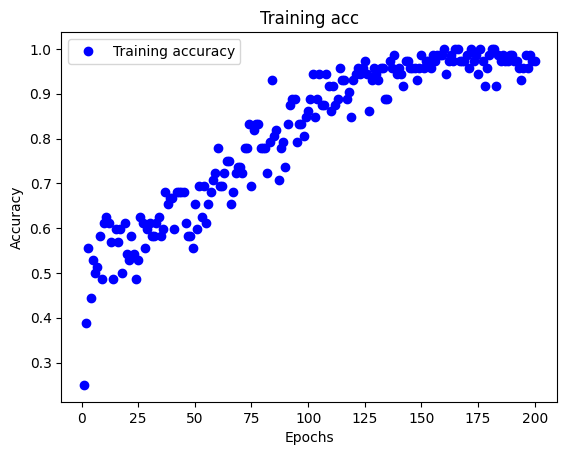

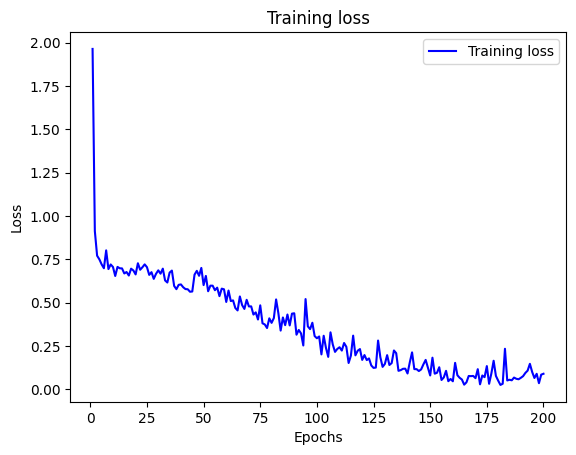

In [22]:
import os
import matplotlib.pyplot as plt
#os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import csv
import torch
# Set the environment variable for CUDA memory allocationos.environ['PYTORCH CUDA ALLOC CONF']= 'expandable_segments:True
# Rest of your script
# Ensure that CUDA is available and set the device
global ii
ii=0
if torch.cuda.is_available():
    device =torch.device("cuda")
    print("CUDA is available.")# Your CUDA operations here 
else:
    print("CUDA is not available. Running on CPU instead.")

train_loss_list = []
train_acc_list = []
total_step = len(train_loader)
time_list = []
for epoch in range(num_epochs):
       
    start = time.time()
    per_epoch_loss = 0
    num_correct= 0
    val_num_correct = 0 
    test_num_correct = 0
    model.train()
    with torch.enable_grad():
        for x,label in tqdm(train_loader):

            x = x.to(device)
            label = label.to(device)
            label = torch.squeeze(label)# label的形状是 [256,1] 要将其变成 [256]
            label = label.long()
            # Forward pass
            logits = model(x)
            loss = criterion(logits, label)

            per_epoch_loss += loss.item()

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            pred = logits.argmax(dim=1)
            num_correct += torch.eq(pred, label).sum().float().item()
        print("Train Epoch: {}\t Loss: {:.6f}\t Acc: {:.6f}".format(epoch,per_epoch_loss/total_step,num_correct/len(train_loader.dataset)))
        summaryWriter.add_scalars('loss', {"loss":(per_epoch_loss/total_step)}, epoch)
        summaryWriter.add_scalars('acc', {"acc":num_correct/len(train_loader.dataset)}, epoch)
        tran_acc = num_correct/len(train_loader.dataset)
        train_loss = per_epoch_loss/total_step
        train_loss_list.append(train_loss)  #损失率
        train_acc_list.append(tran_acc)   #添加数组
        
    model.eval()
    with torch.no_grad():
        for x,label in tqdm(val_loader):
            x = x.to(device)
            label = label.to(device)
            label = torch.squeeze(label)
            # Forward pass
            logits = model(x)
            pred = logits.argmax(dim=1)
            val_num_correct += torch.eq(pred, label).sum().float().item()
        print("val Epoch: {}\t Val_Acc: {:.6f}".format(epoch,val_num_correct/len(val_loader.dataset)))
        
        summaryWriter.add_scalars('acc', {"val_acc":val_num_correct/len(val_loader.dataset)}, epoch)
        summaryWriter.add_scalars('time', {"time":(time.time() - start)}, epoch)
    scheduler.step()
    
    filenames = []
    with open('/hy-tmp/Abeta_4D_resize/test_list.txt', 'r') as file:
        for line in file:
            filenames.append(line.strip()) 
    results = []
    model.eval()
    
    with torch.no_grad():
        for x,label in tqdm(test_loader):
            x = x.to(device)
            label = label.to(device)
            label = torch.squeeze(label)
            # Forward pass
            logits = model(x)
            pred = logits.argmax(dim=1)
            test_num_correct += torch.eq(pred, label).sum().float().item() 
            for i in range(len(pred)):
                results.append({
                    'file_name': filenames[i],  # 使用从文件中读取的文件名
                    'label': label[i].item(),
                    'predicted_label': pred[i].item()
                })
        print("Test Epoch: {}\t Test_Acc: {:.6f}".format(epoch,test_num_correct/len(test_loader.dataset)))
        ii += 1
        iii = ii - 1
        validationfilename='/validation/validation_results' + str(iii) +'.csv'
        print(validationfilename)
        with open(validationfilename, 'w', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=['file_name', 'label', 'predicted_label'])
            writer.writeheader()
            for result in results:
                writer.writerow(result)

        if (test_num_correct/len(test_loader.dataset)) > 0.83:
            filepath = "./weights"
            folder = os.path.exists(filepath)
            if not folder:
                    # 判断是否存在文件夹如果不存在则创建为文件夹
                os.makedirs(filepath)
            path = './weights/model' + str(epoch) + '.pth'
            save_model(model, path)
        
        summaryWriter.add_scalars('acc', {"test_acc":test_num_correct/len(test_loader.dataset)}, epoch)
        summaryWriter.add_scalars('time', {"time":(time.time() - start)}, epoch)
    scheduler.step()

#绘图数据
Afile_path = '/validation/training_accuracy.csv'
Lfile_path = '/validation/training_loss.csv'
# 写入数据到 CSV 文件
with open(Afile_path, 'w', newline='') as file:
    writer = csv.writer(file) 
    # 写入标题行
    writer.writerow(['Epoch', 'Accuracy'])    
    # 写入数据行
    for epoch, accuracy in zip(range(1, num_epochs + 1), train_acc_list):
        writer.writerow([epoch, accuracy])
print(f"Data written to {Afile_path}")

with open(Lfile_path, 'w', newline='') as file:
    writer = csv.writer(file) 
    # 写入标题行
    writer.writerow(['Epoch', 'Loss'])    
    # 写入数据行
    for epoch, loss in zip(range(1, num_epochs + 1), train_loss_list):
        writer.writerow([epoch, loss])
print(f"Data written to {Lfile_path}")

epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_acc_list, 'bo', label='Training accuracy')
plt.title('Training acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_loss_list, 'b', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()



In [23]:
def generate_model1(model_type='resnet', model_depth=18,
                   input_W=224, input_H=224, input_D=224, resnet_shortcut='B',
                   no_cuda=False, gpu_id=[0],
                   pretrain_path = '/MedicalNet/pretrain/resnet_18.pth',
                   nb_class=11):
    assert model_type in [
        'resnet'
    ]

    if model_type == 'resnet':
        assert model_depth in [10, 18, 34, 50, 101, 152, 200]

    if model_depth == 10:
        model = resnet.resnet10(
            sample_input_W=input_W,
            sample_input_H=input_H,
            sample_input_D=input_D,
            shortcut_type=resnet_shortcut,
            no_cuda=no_cuda,
            num_seg_classes=1)
        fc_input = 256
    elif model_depth == 18:
        model = resnet.resnet18(
            sample_input_W=input_W,
            sample_input_H=input_H,
            sample_input_D=input_D,
            shortcut_type=resnet_shortcut,
            no_cuda=no_cuda,
            num_seg_classes=1)
        fc_input = 512
    elif model_depth == 34:
        model = resnet.resnet34(
            sample_input_W=input_W,
            sample_input_H=input_H,
            sample_input_D=input_D,
            shortcut_type=resnet_shortcut,
            no_cuda=no_cuda,
            num_seg_classes=1)
        fc_input = 512
    elif model_depth == 50:
        model = resnet.resnet50(
            sample_input_W=input_W,
            sample_input_H=input_H,
            sample_input_D=input_D,
            shortcut_type=resnet_shortcut,
            no_cuda=no_cuda,
            num_seg_classes=1)
        fc_input = 2048
    elif model_depth == 101:
        model = resnet.resnet101(
            sample_input_W=input_W,
            sample_input_H=input_H,
            sample_input_D=input_D,
            shortcut_type=resnet_shortcut,
            no_cuda=no_cuda,
            num_seg_classes=1)
        fc_input = 2048
    elif model_depth == 152:
        model = resnet.resnet152(
            sample_input_W=input_W,
            sample_input_H=input_H,
            sample_input_D=input_D,
            shortcut_type=resnet_shortcut,
            no_cuda=no_cuda,
            num_seg_classes=1)
        fc_input = 2048
    elif model_depth == 200:
        model = resnet.resnet200(
            sample_input_W=input_W,
            sample_input_H=input_H,
            sample_input_D=input_D,
            shortcut_type=resnet_shortcut,
            no_cuda=no_cuda,
            num_seg_classes=1)
        fc_input = 2048

    model.conv_seg = nn.Sequential(nn.AdaptiveAvgPool3d((1, 1, 1)), nn.Flatten(),
                                   nn.Linear(in_features=fc_input, out_features=nb_class, bias=True))

    if not no_cuda:
        if len(gpu_id) > 1:
            model = model.cuda()
            model = nn.DataParallel(model, device_ids=gpu_id)
            net_dict = model.state_dict()
        else:
            import os
            os.environ["CUDA_VISIBLE_DEVICES"]=str(gpu_id[0])
            model = model.cuda()
            model = nn.DataParallel(model, device_ids=None)
            net_dict = model.state_dict()
    else:
        net_dict = model.state_dict()

    print('loading pretrained model {}'.format(pretrain_path))
    pretrain = torch.load(pretrain_path)
    #pretrain_dict = {k: v for k, v in pretrain['state_dict'].items() if k in net_dict.keys()}
    # k 是每一层的名称，v是权重数值
    #net_dict.update(pretrain_dict) #字典 dict2 的键/值对更新到 dict 里。
    #model.load_state_dict(net_dict) #model.load_state_dict()函数把加载的权重复制到模型的权重中去

    print("-------- pre-train model load successfully --------")

    return model


In [42]:
modelval = generate_model1(model_type='resnet', model_depth=18,
                   input_W=224, input_H=224, input_D=224, resnet_shortcut='B',
                   no_cuda=False, gpu_id=[0],
                   pretrain_path = '/weights/model197.pth',
                   nb_class=11)

loading pretrained model /weights/model197.pth
-------- pre-train model load successfully --------
